In [ ]:
!pip install datasets
!pip install colorama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

model="drive/MyDrive/thesis-work/model_local"

Mounted at /content/drive


In [ ]:
CONFIG = {"seed": 2022,
          "epochs": 3,
          "model_name": "drive/MyDrive/thesis-work/model_local",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

In [ ]:
df = pd.read_csv('trafficcontrol_data.csv')

# Drop NaN values and reset index of dataframe
df = df[df['text'].notna()]
df = df.reset_index()
df.drop(columns=["index"] , inplace=True)

In [ ]:
df

,text,label
0,cache group dashboard,1
1,this will need to be rebased as next time the ...,0
2,because neither of those as of today have mana...,0
3,everything that depends on to seems to be fail...,0
4,i also believe that our current eslint plugin ...,0
5,i m assuming you opened this pr to look for fe...,0
6,rebased onto,0
7,r traeak,0
8,looks like ubuntu runners no longer support py...,0


In [ ]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [ ]:
class TD_Model(nn.Module):
    def __init__(self, model_name):
        super(TD_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])

    def forward(self, ids, mask):
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

<h2> Testing Inference </h2>


In [ ]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [ ]:
test_df = df

In [ ]:
test_df

,text,label
0,cache group dashboard,1
1,this will need to be rebased as next time the ...,0
2,because neither of those as of today have mana...,0
3,everything that depends on to seems to be fail...,0
4,i also believe that our current eslint plugin ...,0
5,i m assuming you opened this pr to look for fe...,0
6,rebased onto,0
7,r traeak,0
8,looks like ubuntu runners no longer support py...,0


In [ ]:
class TD_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )

        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],

        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']

        return samples

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = TD_Model(CONFIG['model_name'])

In [ ]:
def prepare_test_loader(test_df):
    test_dataset = TD_TestDataset(test_df,
                                   tokenizer=CONFIG['tokenizer'],
                                   max_length=CONFIG['max_length'])

    test_loader = DataLoader(test_dataset,
                             batch_size=CONFIG['valid_batch_size'],
                             collate_fn=collate_fn,
                             num_workers=2,
                             shuffle=False,
                             pin_memory=True,
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [ ]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)

    bar = tqdm(enumerate(test_loader), total=len(test_loader))

    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)

        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()

        preds.append(y_preds)
        preds_target.append(pred_target)
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [ ]:
predictions = []
predictions_labels = []

predictions, predictions_labels = inference(test_loader, model, CONFIG['device'])

# Clean up
torch.cuda.empty_cache()

100%|██████████| 1/1 [00:09<00:00,  9.40s/it]


In [ ]:
#deberta model inference
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))

    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)

    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

KeyError: 'n_fold'

In [ ]:
len(predictions)

9

In [ ]:
predictions

array([[0.44287714, 0.5571228 ],
       [0.3794444 , 0.6205556 ],
       [0.5689726 , 0.4310274 ],
       [0.49506822, 0.5049318 ],
       [0.51462185, 0.48537812],
       [0.5461151 , 0.45388484],
       [0.51700056, 0.4829994 ],
       [0.5678557 , 0.43214428],
       [0.5952045 , 0.40479556]], dtype=float32)

In [ ]:
test_df["prediction_0"] = predictions[:, 0]

In [ ]:
test_df["prediction_1"] = predictions[:, 1]

In [ ]:
test_df

,text,label,prediction_0,prediction_1
0,cache group dashboard,1,0.442877,0.557123
1,this will need to be rebased as next time the ...,0,0.379444,0.620556
2,because neither of those as of today have mana...,0,0.568973,0.431027
3,everything that depends on to seems to be fail...,0,0.495068,0.504932
4,i also believe that our current eslint plugin ...,0,0.514622,0.485378
5,i m assuming you opened this pr to look for fe...,0,0.546115,0.453885
6,rebased onto,0,0.517001,0.482999
7,r traeak,0,0.567856,0.432144
8,looks like ubuntu runners no longer support py...,0,0.595204,0.404796


In [ ]:
len(test_df)

9

In [ ]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [ ]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [ ]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [ ]:
test_df["pred"] = test_df["pred"].astype(int)

In [ ]:
test_df

,text,label,prediction_0,prediction_1,Max,pred
0,cache group dashboard,1,0.442877,0.557123,prediction_1,1
1,this will need to be rebased as next time the ...,0,0.379444,0.620556,prediction_1,1
2,because neither of those as of today have mana...,0,0.568973,0.431027,prediction_0,0
3,everything that depends on to seems to be fail...,0,0.495068,0.504932,prediction_1,1
4,i also believe that our current eslint plugin ...,0,0.514622,0.485378,prediction_0,0
5,i m assuming you opened this pr to look for fe...,0,0.546115,0.453885,prediction_0,0
6,rebased onto,0,0.517001,0.482999,prediction_0,0
7,r traeak,0,0.567856,0.432144,prediction_0,0
8,looks like ubuntu runners no longer support py...,0,0.595204,0.404796,prediction_0,0


In [ ]:
#add the lable from the repository into the data after inference to use it as a ground truth
labled_test_df = pd.read_csv('labled_data.csv')
labled_test_df

,text,pred,label
0,update required node version to eslin...,1,bug\nlow\nimpact\nexperimental\ndependencies\n...
1,add origins page traffic portal ad...,1,new\nfeature\nlow\nimpact\nexperimental\ntraff...
2,add origins page traffic portal ad...,0,new\nfeature\nlow\nimpact\nexperimental\ntraff...
3,chore config eslint jsdoc tag lines update...,1,bug\nlow\nimpact\nexperimental\ndependencies\n...
4,revert eslint jsdoc update required node v...,1,bug\nlow\nimpact\nexperimental\ndependencies\n...
...,...,...,...
100,revert eslint jsdoc update required node v...,1,bug\nlow\nimpact\nexperimental\ndependencies\n...
101,enable eslint methoddefinition update requi...,1,bug\nlow\nimpact\nexperimental\ndependencies\n...
102,fix turn off eslint jsdoc rules update req...,1,bug\nlow\nimpact\nexperimental\ndependencies\n...
103,fix test delete origin add origins page traffi...,1,new\nfeature\nlow\nimpact\nexperimental\ntraff...


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[6 2]
 [0 1]]


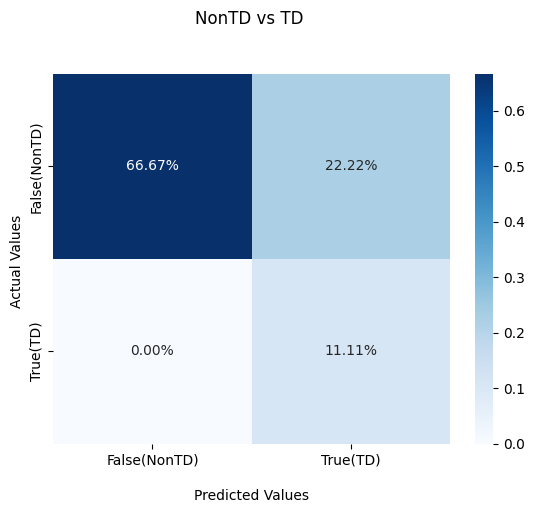

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title('NonTD vs TD \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonTD)','True(TD)'])
ax.yaxis.set_ticklabels(['False(NonTD)','True(TD)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.33      1.00      0.50         1

    accuracy                           0.78         9
   macro avg       0.67      0.88      0.68         9
weighted avg       0.93      0.78      0.82         9



In [ ]:
test_df[["text","pred","label"]].to_csv("Test_Inference_data.csv")